## The 2nd model added to skip connection

<ipython-input-1-c140f4dfb625>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-1-c140f4dfb625>:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


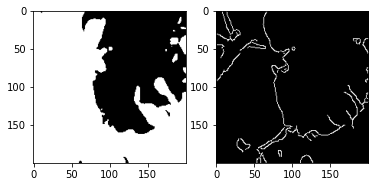

In [1]:
#Prepare for training data
import cv2, matplotlib
import numpy as np
import glob, os
import matplotlib.pyplot as plt

path="training/"
files= glob.glob(os.path.join(path, '*.jpg'))
files.sort()

#Load the image data (Jpg) 
data=[]
for i,file in  enumerate(files):
    cups = cv2.imread(file)
    #preprocess by blurring and grayscale
    cups_preprocessed  = cv2.cvtColor(cv2.GaussianBlur(cups, (7,7), 0), cv2.COLOR_BGR2GRAY)
    #find binary image with edges
    _, cups_thresh = cv2.threshold(cups_preprocessed, 30, 255, cv2.THRESH_BINARY)
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(cups_thresh, cv2.COLOR_GRAY2RGB))
    data.append(cups_preprocessed)
files.sort()
files_length = len(files)

#Detection of edge of object in images
# save them as png file
for ii in range(files_length):
    
    cups_edges = cv2.Canny(data[ii], threshold1=30, threshold2=60) #Canny Edge Detection 
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(cups_edges, cv2.COLOR_GRAY2RGB))
   
    cv2.imwrite(os.path.join(path, 'T0{}.png'.format(ii)),cups_edges )
    cv2.waitKey(0)
#Now we got two kinds of images 
# save them as png file

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [3]:
# loading training data
# I used images of different glaciers (Greenland, Patagonia, Alaska and somehwere in the world)  as training data
import glob
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

files = glob.glob('training/*.jpg')

imgs = np.array([img_to_array(load_img(f)) for f in files])

imgs.shape

(200, 200, 200, 3)

In [4]:
# loading label data
# Classified label data as 1 and 0 using threshold (128)

import os

th = 128

labels = np.array([img_to_array(load_img(f"{os.path.splitext(f)[0]}.png", color_mode = 'grayscale')) for f in files])

labels[labels < th] = 0  #(should be black)

labels[labels >= th] = 1 #(should be white)

labels.shape

(200, 200, 200, 1)

In [59]:
from keras.models import Model
from keras.layers import Input, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPool2D
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D,concatenate,Conv2DTranspose,Lambda,Multiply,Add,Dense
#########################
#Build up Autoencoder
#########################

OUTPUT_CHANNELS = 3
IMG_HEIGHT =200
IMG_WIDTH =200

inputs = Input((IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS))

#input = Input(shape = imgs.shape[1:])

#x = input

#inputs = BatchNormalization()(inputs)

# Encoder

c1 = Conv2D(32, 3, padding='same', activation = 'relu')(inputs) #channel changed (16-32) 
p1 = MaxPool2D()(c1)

p1 = BatchNormalization()(p1)
d1 = Dropout(0.2)(p1)

c2 = Conv2D(64, 3, padding='same', activation = 'relu')(d1) #channel changed (32-64) 
c2 = Conv2D(64, 3, padding='same', activation = 'relu')(c2)
c2 = Conv2D(64, 3, padding='same', activation = 'relu')(c2)
p2 = MaxPool2D()(c2)

p2 = BatchNormalization()(p2)
d2 = Dropout(0.2)(p2)

c3 = Conv2D(128, 3, padding='same', activation = 'relu')(d2)#channel changed (64-128) 
c3 = Conv2D(128, 3, padding='same', activation = 'relu')(c3)
c3 = Conv2D(128, 3, padding='same', activation = 'relu')(c3)
p3 = MaxPool2D()(c3)

p3 = BatchNormalization()(p3)
d3 = Dropout(0.3)(p3)

c4 = Conv2D(256, 3, padding='same', activation = 'relu')(d3)#channel changed (128-256) 
c4 = Conv2D(256, 3, padding='same', activation = 'relu')(c4)

c4 = BatchNormalization()(c4)
d4 = Dropout(0.5)(c4)
##########
#mid = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p6)
# Decoder

u5 = Conv2DTranspose(128, 3, strides = 2, padding='same', activation = 'relu')(d4)
c5 = concatenate([u5, c3])  #skip connection
c5 = Conv2D(128, 3, padding='same', activation = 'relu')(c5)
c5 = Conv2D(128, 3, padding='same', activation = 'relu')(c5)
c5 = Conv2D(128, 3, padding='same', activation = 'relu')(c5)

c5 = BatchNormalization()(c5)
d5 = Dropout(0.2)(c5)

u6 = Conv2DTranspose(32, 3, strides = 2, padding='same', activation = 'relu')(d5)
c6 = concatenate([u6, c2])#skip connection
c6 = Conv2D(64, 3, padding='same', activation = 'relu')(c6)
c6 = Conv2D(64, 3, padding='same', activation = 'relu')(c6)
c6 = Conv2D(64, 3, padding='same', activation = 'relu')(c6)

c6 = BatchNormalization()(c6)
d6 = Dropout(0.3)(c6)

u7 = Conv2DTranspose(16, 3, strides = 2, padding='same', activation = 'relu')(d6)
c7 = concatenate([u7, c1])#skip connection
c7 = Conv2D(32, 3, padding='same', activation = 'relu')(c7)

c7 = BatchNormalization()(c7)
d7 = Dropout(0.5)(c7)

outputs = Conv2D(1, 1, activation = 'sigmoid')(d7)


#Define the model
model = Model(inputs=[inputs], outputs=[outputs])

model.compile(loss = 'mse', optimizer = 'adam',  metrics=['mae', 'acc'])

model.summary()


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_705 (Conv2D)             (None, 200, 200, 32) 896         input_55[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_227 (MaxPooling2D (None, 100, 100, 32) 0           conv2d_705[0][0]                 
__________________________________________________________________________________________________
batch_normalization_264 (BatchN (None, 100, 100, 32) 128         max_pooling2d_227[0][0]          
_______________________________________________________________________________________

In [ ]:
hist = model.fit(imgs, labels, initial_epoch = 120,epochs =160 , batch_size =10)

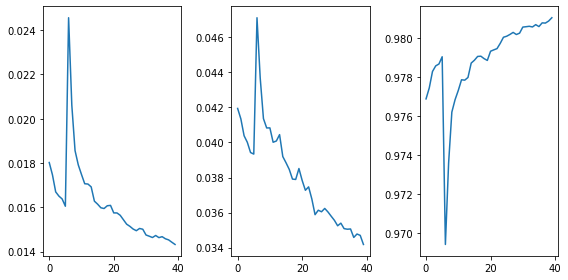

In [75]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 4)

plt.subplot(1, 3, 1)
plt.plot(hist.history['loss'])

plt.subplot(1, 3, 2)
plt.plot(hist.history['mae'])

plt.subplot(1, 3, 3)
plt.plot(hist.history['acc'])
plt.tight_layout()

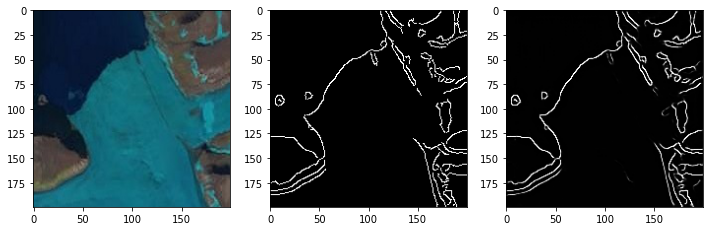

In [76]:
def predict(index, s = 12.0):
    plt.rcParams['figure.figsize'] = (s, s)

    sh = imgs.shape[1:-1]

    # detection of outline of glaciers
    pred = model.predict(np.array([imgs[index]]))[0]
    pred *= 255

    plt.subplot(1, 3, 1)
    # Show the raw image
    plt.imshow(imgs[index].astype(int))

    plt.subplot(1, 3, 2)
    # show the label image (the edge of objects)
    plt.imshow(labels[index].reshape(sh), cmap = 'gray')

    plt.subplot(1, 3, 3)
    # the result of predictions
    plt.imshow(pred.reshape(sh).astype(int), cmap = 'gray')

predict(10)

In [77]:
def predict_eval(file, s = 10.0):
    plt.rcParams['figure.figsize'] = (s, s)

    img = img_to_array(load_img(file))

    # Detection of outline of glaciers
    pred = model.predict(np.array([img]))[0]
    pred *= 255
    #pred_data.append(pred)
    
    plt.subplot(1, 2, 1)
    # show the raw image
    plt.imshow(img.astype(int))

    plt.subplot(1, 2, 2)
    # the result of prediction based on the satellite image wihch have never trained in the model
    plt.imshow(pred.reshape(pred.shape[:-1]).astype(int), cmap = 'gray')
    cv2.imwrite("try12_pred.png", pred.reshape(pred.shape[:-1]).astype(int))

In [8]:
#Save the above model
model.save('model/newmodel_200_chanelchange.h5')

In [9]:
#Import the model I made
# We can run the model you like here

from keras.models import load_model
model_file='model/newmodel_200_chanelchange.h5'
model = load_model(model_file)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_705 (Conv2D)             (None, 200, 200, 32) 896         input_55[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_227 (MaxPooling2D (None, 100, 100, 32) 0           conv2d_705[0][0]                 
__________________________________________________________________________________________________
batch_normalization_264 (BatchN (None, 100, 100, 32) 128         max_pooling2d_227[0][0]          
_______________________________________________________________________________________

In [10]:
import sys
import os
import glob
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import cv2
import matplotlib.pyplot as plt

path="prediction/"
files= glob.glob(os.path.join(path, '*.jpg'))
files.sort()
files_length = len(files)


def predict_eval(files, s = 5.0):
    for i in files:
        img = img_to_array(load_img(files))
        plt.rcParams['figure.figsize'] = (s, s)
    # Detection of outline
        pred = model.predict(np.array([img]))[0]
        pred *= 255
    #pred_data.append(pred)
    
        plt.subplot(1, 2, 1)
    # show the raw image
        plt.imshow(img.astype(int))

        plt.subplot(1, 2, 2)
    # the result of prediction based on the satellite image wihch have never trained in the model
        plt.imshow(pred.reshape(pred.shape[:-1]).astype(int), cmap = 'gray')
#for ii in range(files_length):
        cv2.imwrite(os.path.join(path, 'try{}.png'.format(i)),pred.reshape(pred.shape[:-1]).astype(int))
        
    #cv2.imwrite("try13_pred.png", pred.reshape(pred.shape[:-1]).astype(int))
    

prediction\try0.jpg


<ipython-input-10-ce4cbefaba16>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)
<ipython-input-10-ce4cbefaba16>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 2)


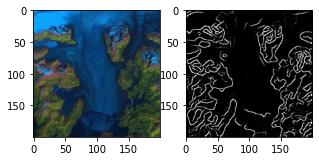

prediction\try1.jpg


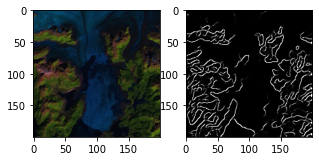

prediction\try2.jpg


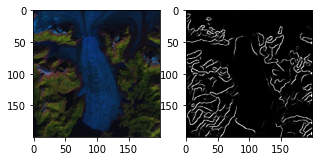

prediction\try3.jpg


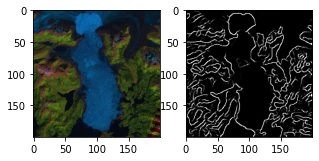

prediction\try4.jpg


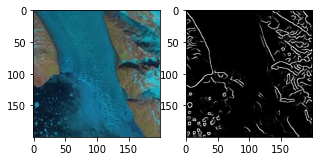

prediction\try5.jpg


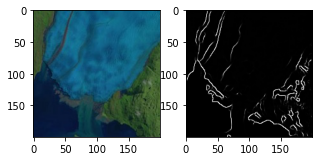

prediction\try6.jpg


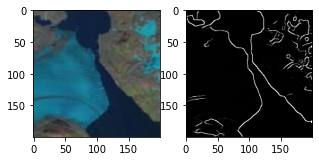

prediction\try7.jpg


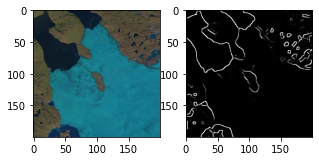

prediction\try8.jpg


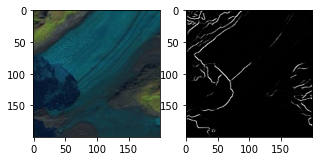

prediction\try9.jpg


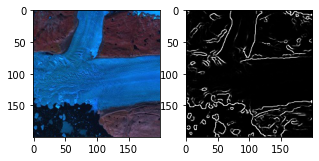

In [11]:
#Prediction of outline of glaciers in the image
path="prediction/"
files= glob.glob(os.path.join(path, '*.jpg'),recursive=True)
files.sort()
for file in files:
    print(file)
    predict_eval(file)
    plt.show()

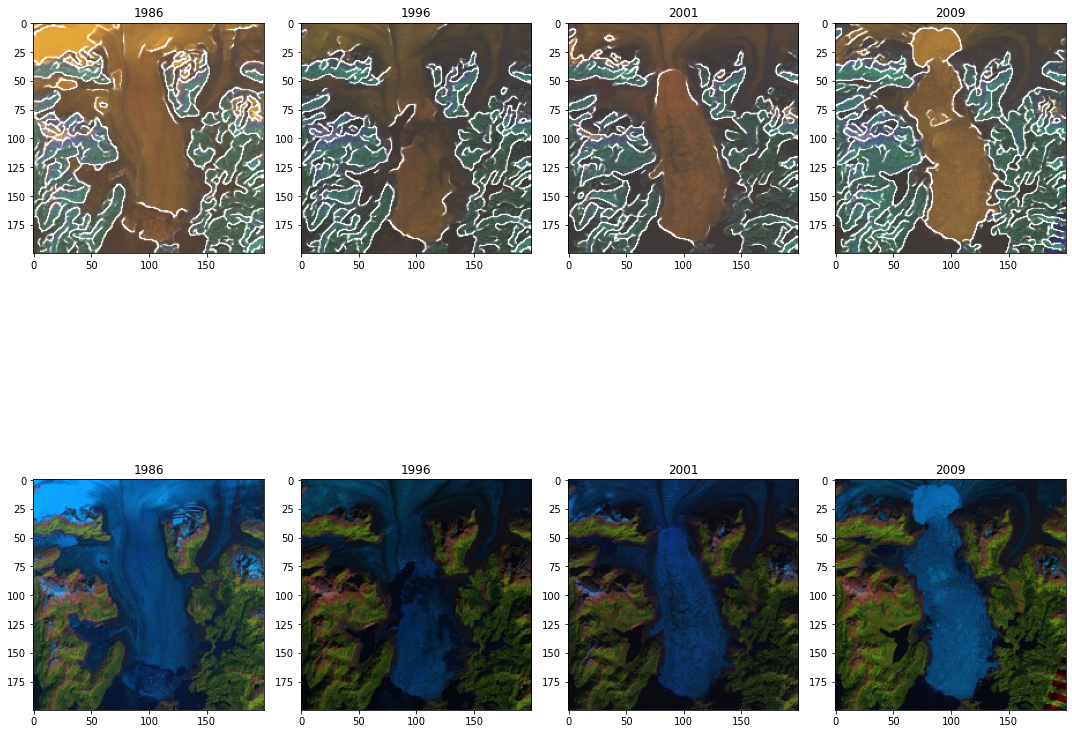

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
#Overlay the prediction with raw data
plt.figure(figsize=(15,15))

img1 = cv2.imread('prediction/try0.jpg')
img2 = cv2.imread('prediction/try0.png')
img3 = cv2.imread('prediction/try1.jpg')
img4 = cv2.imread('prediction/try1.png')
img5 = cv2.imread('prediction/try2.jpg')
img6 = cv2.imread('prediction/try2.png')
img7 = cv2.imread('prediction/try3.jpg')
img8 = cv2.imread('prediction/try3.png')


blended = cv2.addWeighted(src1=img1,alpha=0.7,src2=img2,beta=2.0,gamma=50)
blended1 = cv2.addWeighted(src1=img3,alpha=0.7,src2=img4,beta=2.0,gamma=50)
blended2 = cv2.addWeighted(src1=img5,alpha=0.7,src2=img6,beta=2.0,gamma=50)
blended3 = cv2.addWeighted(src1=img7,alpha=0.7,src2=img8,beta=2.0,gamma=50)

plt.subplot(2,4,1)
plt.imshow(blended)
plt.title('1986')
plt.subplot(2,4,2)
plt.imshow(blended1)
plt.title('1996')
plt.subplot(2,4,3)
plt.imshow(blended2)
plt.title('2001')
plt.subplot(2,4,4)
plt.imshow(blended3)
plt.title('2009')

plt.subplot(2,4,5)
plt.imshow(img1)
img0 = img_to_array(load_img('prediction/try0.jpg'))
plt.imshow(img0.astype(int))
plt.title('1986')

plt.subplot(2,4,6)
img1 = img_to_array(load_img('prediction/try1.jpg'))
plt.imshow(img1.astype(int))
#plt.imshow(img3)
plt.title('1996')

plt.subplot(2,4,7)
plt.title('2001')
img2 = img_to_array(load_img('prediction/try2.jpg'))
plt.imshow(img2.astype(int))

plt.subplot(2,4,8)
img3 = img_to_array(load_img('prediction/try3.jpg'))
plt.imshow(img3.astype(int))
#plt.imshow(img7)
plt.title('2009')


plt.tight_layout()
plt.show()

### 2nd model makes it much better to detect the outline of glaciers in detail in comparison to the 1st model